In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from torch import cuda, backends
from typing import Tuple, List
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json


In [6]:
with open('../../multicite/data/classification_1_context/test.json', 'r') as f:
    content = f.read()

json_content = json.loads(content)

In [8]:
class CitationClassifier:
    def __init__(self, model_checkpoint):
        tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, model_max_length = 512)
        model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)

        device = 'mps' if backends.mps.is_available() else 'cuda' if cuda.is_available() else 'cpu'

        self.classifier = pipeline('text-classification', model=model, tokenizer=tokenizer, device = device)

        i = 2
        with open(f'words/background_words{i}.txt', 'r') as f:
            self.background_words = f.read().split(',')
        with open(f'words/result_words{i}.txt', 'r') as f:
            self.results_words = f.read().split(',')
        with open(f'words/method_words{i}.txt', 'r') as f:
            self.method_words = f.read().split(',')

    def apply_classifier_model(self, text) -> Tuple[str, float]:
        threshold = 0
        results = self.classifier(text, truncation = True)

        ordering = ['extends', 'uses', 'differences', 'similarities', 'future_work', 'motivation', 'background']

        labels = [(result['label'], result['score']) for result in results if result['score'] >= threshold]

        return next(iter(sorted(labels, key=lambda s: ordering.index(s[0]))), None)
    
    def score_from_counts(self, counts: List[int], labels = List[str]):
        max_val = max(counts)
        penult_val = 0 if len(counts) == 1 else sorted(counts)[1]
        lead = max_val - penult_val
        
        score_mapping = {0: 0,
                         1: .80,
                         2: .98,
                         3: 1}
        score_mapping_fn = lambda i: score_mapping.get(min(i, 3))
        
        max_label = labels[np.argmax(counts)]
        
        return max_label, score_mapping_fn(lead)
    

    def get_heuristic_score(self, text):
        if (isinstance(text, list)):
            text = ' '.join(text)
        text = text.lower()
        background_count = np.array(list(map(lambda s: s in text, self.background_words))).sum()
        results_count = np.array(list(map(lambda s: s in text, self.results_words))).sum()
        method_count = np.array(list(map(lambda s: s in text, self.method_words))).sum()

        value, score = self.score_from_counts([background_count, results_count, method_count],
                                              ['background', 'result', 'method'])
        

        return value, score
    
    def get_classification(self, text):
        heuristic_value, heuristic_score = self.get_heuristic_score(text)
        classifier_value, classifier_score  = self.apply_classifier_model(text)
        
        if (classifier_score >= heuristic_score or True):
            return classifier_value

        return heuristic_value
        

classifier = CitationClassifier("allenai/multicite-multilabel-scibert")

In [9]:
def get_highest_pref_item(s: str):
    items = s.split(' ')
    ordering = ['extends', 'uses', 'differences', 'similarities', 'future_work', 'motivation', 'background']

    return next(iter(sorted(items, key=ordering.index)), None)

get_highest_pref_item('differences uses background')

'uses'

In [10]:
for sentence in tqdm(json_content):
    if (len(sentence['x']) > 0):
      sentence['z'] = classifier.get_classification(sentence['x'])
    else:
      continue

100%|██████████| 3313/3313 [01:09<00:00, 47.73it/s]


In [11]:
print(f"Total json_content length: {len(json_content)}")
filtered_json_content = list(filter(lambda s: s.get('y') and s.get('z'), json_content))

true_labels_proto = [sentence['y'] for sentence in filtered_json_content]


true_labels = np.array([get_highest_pref_item(sentence) for sentence in true_labels_proto])
predicted_labels = np.array([sentence['z'] for sentence in filtered_json_content])
print(f"Mapping input set: {set(predicted_labels).union(set(true_labels))}")

'''drop_future_work = (true_labels != 'future_work') & (predicted_labels != 'future_work')
print(f"Non future_work entries: {drop_future_work.sum()}")
true_labels = true_labels[drop_future_work]
predicted_labels = predicted_labels[drop_future_work]'''

mapping = lambda s: {
            'differences': 'result',
            'similarities': 'result',
            'motivation': 'background',
            'extends':'method',
            'uses': 'method',
            'future_work':'background',
            'background': 'background'}.get(s) or s


true_labels = np.array(list(map(mapping, true_labels.tolist())))
predicted_labels = np.array(list(map(mapping, predicted_labels.tolist())))



print(f"Mapping output set: {set(predicted_labels)}")
print(f"Finally result size: {len(predicted_labels)}")
print(f"Missing original sentence for {len(list(filter(lambda s: len(s['x']) == 0, json_content)))}")

Total json_content length: 3313
Mapping input set: {'uses', 'extends', 'future_work', 'background', 'differences', 'motivation', 'similarities'}
Mapping output set: {'result', 'background', 'method'}
Finally result size: 3289
Missing original sentence for 24


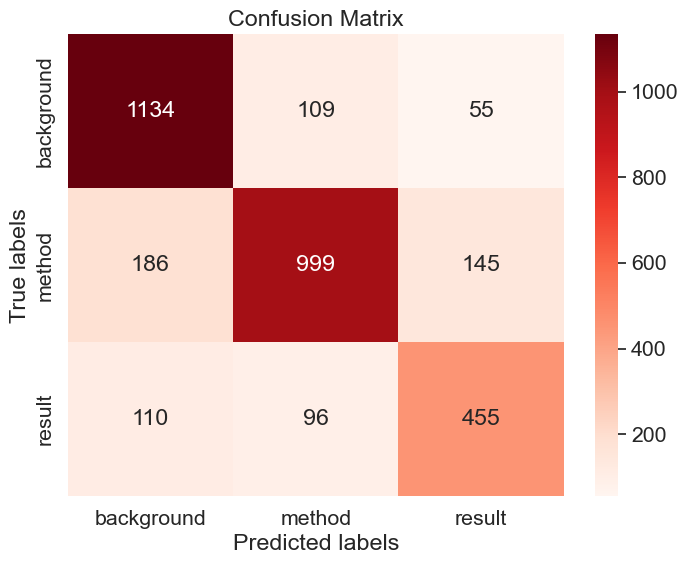

In [15]:
cm = confusion_matrix(true_labels, predicted_labels)
#cm = confusion_matrix(true_labels, predicted_labels, normalize = 'true').round(2)
perm = [0,1,2]

cm = cm[perm][:, perm]
xticks = np.unique(true_labels)[perm]
yticks = np.unique(predicted_labels)[perm]


# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)  # Adjust font size
sns.heatmap(cm, annot=True, fmt='g', cmap='Reds', xticklabels=xticks, yticklabels=yticks)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

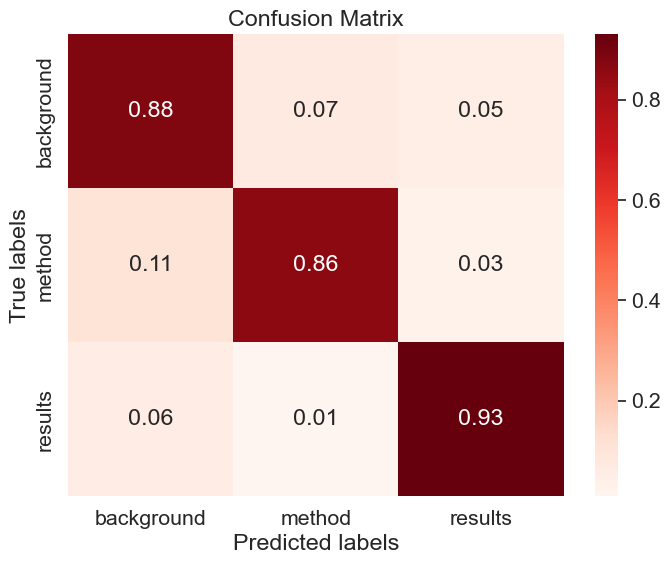

In [29]:
ar1 = np.array([True, True, False, False])
ar2 = np.array([True, False, True, False])


print(ar1 | ar2)
print(ar1 or ar2)

[ True  True  True False]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()